<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =====================================================
# セル1: MVTec AD を mydrive 直リンクからダウンロード＆展開（Drive不要）
# - TARGET="all" なら全体 (~5GB)
# - それ以外はクラス名（例: "bottle"）のみをダウンロード
# - 展開先: /content/mvtec_anomaly_detection/<class>/...
# - 互換リンク: /content/mvtec -> /content/mvtec_anomaly_detection
# =====================================================

import os, subprocess, tarfile, zipfile, glob

TARGET = "bottle"  # "all" または 15クラス名のいずれか: bottle,cable,capsule,carpet,grid,hazelnut,leather,metal_nut,pill,screw,tile,toothbrush,transistor,wood,zipper
DEST_PARENT = "/content"
DEST_ROOT   = os.path.join(DEST_PARENT, "mvtec_anomaly_detection")
COMP_LINK   = "/content/mvtec"  # 互換リンク

WHOLE_URL = "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938113-1629952094/mvtec_anomaly_detection.tar.xz"
CLASS_URLS = {
    "bottle":      "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz",
    "cable":       "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937413-1629951498/cable.tar.xz",
    "capsule":     "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937454-1629951595/capsule.tar.xz",
    "carpet":      "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz",
    "grid":        "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937487-1629951814/grid.tar.xz",
    "hazelnut":    "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937545-1629951845/hazelnut.tar.xz",
    "leather":     "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937607-1629951964/leather.tar.xz",
    "metal_nut":   "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937637-1629952063/metal_nut.tar.xz",
    "pill":        "https://www.mydrive.ch/shares/43421/11a215a5749fcfb75e331ddd5f8e43ee/download/420938129-1629953099/pill.tar.xz",
    "screw":       "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938130-1629953152/screw.tar.xz",
    "tile":        "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938133-1629953189/tile.tar.xz",
    "toothbrush":  "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938134-1629953256/toothbrush.tar.xz",
    "transistor":  "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938166-1629953277/transistor.tar.xz",
    "wood":        "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938383-1629953354/wood.tar.xz",
    "zipper":      "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938385-1629953449/zipper.tar.xz",
}
IMG_EXTS = ('*.png','*.jpg','*.jpeg','*.bmp','*.tif','*.tiff')

def run(cmd):
    print("[RUN]", cmd)
    rc = subprocess.call(cmd, shell=True)
    if rc != 0:
        raise RuntimeError(f"Command failed (rc={rc}): {cmd}")

def list_images_multi_ext(dirpath: str):
    files=[]
    for ext in IMG_EXTS:
        files += glob.glob(os.path.join(dirpath, '**', ext), recursive=True)
    return sorted(files)

os.makedirs(DEST_ROOT, exist_ok=True)

if TARGET == "all":
    tar_path = os.path.join(DEST_PARENT, "mvtec_ad.tar.xz")
    run(f'wget --progress=dot:mega -O "{tar_path}" "{WHOLE_URL}"')
    run(f'tar -xf "{tar_path}" -C "{DEST_PARENT}"')
else:
    if TARGET not in CLASS_URLS:
        raise ValueError(f"Unknown TARGET='{TARGET}'.")
    tar_path = os.path.join(DEST_PARENT, f"{TARGET}.tar.xz")
    run(f'wget --progress=dot:mega -O "{tar_path}" "{CLASS_URLS[TARGET]}"')
    run(f'tar -xf "{tar_path}" -C "{DEST_ROOT}"')

# 互換リンク（/content/mvtec）が無ければ作成
if not os.path.exists(COMP_LINK):
    try:
        os.symlink(DEST_ROOT, COMP_LINK)
        print("[INFO] Symlink:", COMP_LINK, "->", DEST_ROOT)
    except Exception as e:
        print("[WARN] symlink failed:", e)

# 簡易チェック＆要約
def quick_summary(root_parent="/content"):
    candidates = ["/content/mvtec", "/content/mvtec_anomaly_detection"]
    ok = False
    for base in candidates:
        if not os.path.isdir(base): continue
        classes = [d for d in os.listdir(base) if os.path.isdir(os.path.join(base, d))]
        classes = sorted([c for c in classes if os.path.isdir(os.path.join(base,c,"test")) or os.path.isdir(os.path.join(base,c,"train"))])
        if not classes: continue
        print(f"[READY] Found classes under {base}: {classes[:10]}{' ...' if len(classes)>10 else ''}")
        # 1クラスだけ簡易枚数
        cls0 = classes[0]
        tg = os.path.join(base, cls0, "train", "good")
        ttg= os.path.join(base, cls0, "test",  "good")
        n_tg = len(list_images_multi_ext(tg)) if os.path.isdir(tg) else 0
        n_ttg= len(list_images_multi_ext(ttg)) if os.path.isdir(ttg) else 0
        print(f"[SUMMARY] sample class={cls0}: train/good={n_tg}, test/good={n_ttg}")
        ok = True
    if not ok:
        raise FileNotFoundError("Extraction finished but dataset layout not detected. Please check archive.")
    print("[DONE] MVTec AD is ready under /content/mvtec_anomaly_detection")

quick_summary()


[RUN] wget --progress=dot:mega -O "/content/bottle.tar.xz" "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz"
[RUN] tar -xf "/content/bottle.tar.xz" -C "/content/mvtec_anomaly_detection"
[INFO] Symlink: /content/mvtec -> /content/mvtec_anomaly_detection
[READY] Found classes under /content/mvtec: ['bottle']
[SUMMARY] sample class=bottle: train/good=209, test/good=20
[READY] Found classes under /content/mvtec_anomaly_detection: ['bottle']
[SUMMARY] sample class=bottle: train/good=209, test/good=20
[DONE] MVTec AD is ready under /content/mvtec_anomaly_detection


In [3]:
# =====================================================
# セル2: 「ダウンロード済み」を前提に UNet Autoencoder を学習・評価・可視化
# - ダウンロード処理は一切しません
# - /content/mvtec または /content/mvtec_anomaly_detection を自動検出
# =====================================================

import os, glob, math, random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import roc_auc_score

# ---------------- 基本設定 ----------------
CLASS_NAME = "bottle"  # 学習したいクラス名（セル1でDLしたクラスに合わせる）
IMG_SIZE = 256
CROP_SIZE = 256
EPOCHS   = 50
BATCH    = 16
OUT_DIR  = "./out_unet_ae"

SEED=42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('[Device]', device)

IMG_EXTS = ('*.png','*.jpg','*.jpeg','*.bmp','*.tif','*.tiff')

def list_images_multi_ext(dirpath: str):
    files=[]
    for ext in IMG_EXTS:
        files += glob.glob(os.path.join(dirpath, '**', ext), recursive=True)
    return sorted(files)

# --------- ルート自動検出（ダウンロードはしない）---------
def autodetect_root(class_name: str):
    candidates = [
        "/content/mvtec", "/content/mvtec_anomaly_detection",
        "/content", "/kaggle/input",
    ]
    # 1) 典型レイアウト
    for root in candidates:
        tg = os.path.join(root, class_name, "train", "good")
        ttg= os.path.join(root, class_name, "test",  "good")
        if os.path.isdir(tg) and len(list_images_multi_ext(tg))>0: return root
        if os.path.isdir(ttg) and len(list_images_multi_ext(ttg))>0: return root
    # 2) 広域スキャン
    for base in ["/content", "/kaggle/input"]:
        for path in glob.glob(os.path.join(base, "**", class_name), recursive=True):
            tg = os.path.join(path, "train", "good")
            ttg= os.path.join(path, "test",  "good")
            if (os.path.isdir(tg) and len(list_images_multi_ext(tg))>0) or (os.path.isdir(ttg) and len(list_images_multi_ext(ttg))>0):
                return os.path.dirname(path)
    raise FileNotFoundError(f"Dataset class '{class_name}' not found under /content. Run the download cell first.")

def print_dataset_summary(root, cls):
    tg = os.path.join(root, cls, 'train', 'good')
    ttg= os.path.join(root, cls, 'test',  'good')
    tdir= os.path.join(root, cls, 'test')
    n_tg  = len(list_images_multi_ext(tg)) if os.path.isdir(tg) else 0
    n_ttg = len(list_images_multi_ext(ttg)) if os.path.isdir(ttg) else 0
    subs = [d for d in os.listdir(tdir) if os.path.isdir(os.path.join(tdir,d)) and d!='good'] if os.path.isdir(tdir) else []
    n_an  = sum(len(list_images_multi_ext(os.path.join(tdir, d))) for d in subs) if subs else 0
    print('[SUMMARY]', {'root':root, 'class':cls, 'train/good':n_tg, 'test/good':n_ttg, 'test/anoms':n_an, 'anomaly_types':subs})

# ----------------- Dataset -----------------
class MVTecTrain(Dataset):
    def __init__(self, root: str, cls: str, img_size: int, crop_size: int, val_split: float=0.1, is_val: bool=False):
        tg = os.path.join(root, cls, 'train', 'good')
        files = list_images_multi_ext(tg)
        self.used_test_good = False
        if len(files) == 0:
            ttg = os.path.join(root, cls, 'test', 'good')
            files = list_images_multi_ext(ttg)
            if len(files) == 0:
                raise FileNotFoundError(f"No images in train/good nor test/good under root={root}, class={cls}")
            print('[WARN] train/good missing → using test/good for training (evaluation leakage risk).')
            self.used_test_good = True
        n_val = max(1, int(len(files)*val_split))
        self.files = files[:n_val] if is_val else files[n_val:]
        self.t = transforms.Compose([transforms.Resize(img_size), transforms.CenterCrop(crop_size), transforms.ToTensor()])
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        return self.t(Image.open(self.files[i]).convert('RGB'))

class MVTecTest(Dataset):
    def __init__(self, root: str, cls: str, img_size: int, crop_size: int, exclude_good_if_leak=False):
        test_dir = os.path.join(root, cls, 'test'); gt_dir = os.path.join(root, cls, 'ground_truth')
        if not os.path.isdir(test_dir): raise FileNotFoundError(f'Not found: {test_dir}')
        subdirs = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
        self.items=[]
        for sd in subdirs:
            if exclude_good_if_leak and sd=='good': continue
            for ip in list_images_multi_ext(os.path.join(test_dir, sd)):
                if sd=='good':
                    self.items.append((ip, None, 0))
                else:
                    base = os.path.splitext(os.path.basename(ip))[0]
                    mp = os.path.join(gt_dir, sd, base + '_mask.png')
                    if not os.path.exists(mp):
                        cand = glob.glob(os.path.join(gt_dir, sd, '*_mask.png'))
                        mp = cand[0] if len(cand)>0 else mp
                    self.items.append((ip, mp, 1))
        assert len(self.items)>0, f'No test images in {test_dir}'
        self.ti = transforms.Compose([transforms.Resize(img_size), transforms.CenterCrop(crop_size), transforms.ToTensor()])
        self.tm = transforms.Compose([transforms.Resize(img_size, interpolation=Image.NEAREST),
                                      transforms.CenterCrop(crop_size), transforms.PILToTensor()])
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        ip, mp, y = self.items[i]
        img = self.ti(Image.open(ip).convert('RGB'))
        if mp is None:
            mask = torch.zeros(1, img.shape[1], img.shape[2], dtype=torch.uint8)
        else:
            mask = self.tm(Image.open(mp).convert('L')); mask = (mask>0).to(torch.uint8)
        return img, mask, y

# ----------------- UNet（標準・スキップ弱め版も可能） -----------------
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c,out_c,3,padding=1), nn.BatchNorm2d(out_c), nn.ReLU(True),
            nn.Conv2d(out_c,out_c,3,padding=1), nn.BatchNorm2d(out_c), nn.ReLU(True),
        )
    def forward(self,x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_c=3, base=32):
        super().__init__()
        self.d1=DoubleConv(in_c,base); self.p1=nn.MaxPool2d(2)
        self.d2=DoubleConv(base,base*2); self.p2=nn.MaxPool2d(2)
        self.d3=DoubleConv(base*2,base*4); self.p3=nn.MaxPool2d(2)
        self.d4=DoubleConv(base*4,base*8); self.p4=nn.MaxPool2d(2)
        self.bn=DoubleConv(base*8,base*16)
        self.u4=nn.ConvTranspose2d(base*16,base*8,2,2); self.up4=DoubleConv(base*16,base*8)
        self.u3=nn.ConvTranspose2d(base*8,base*4,2,2);  self.up3=DoubleConv(base*8,base*4)
        self.u2=nn.ConvTranspose2d(base*4,base*2,2,2);  self.up2=DoubleConv(base*4,base*2)
        self.u1=nn.ConvTranspose2d(base*2,base,2,2);    self.up1=DoubleConv(base*2,base)
        self.out=nn.Conv2d(base, in_c, 1)
    def forward(self,x):
        c1=self.d1(x); c2=self.d2(self.p1(c1)); c3=self.d3(self.p2(c2)); c4=self.d4(self.p3(c3))
        b=self.bn(self.p4(c4))
        x=self.u4(b); x=self.up4(torch.cat([x,c4],1))
        x=self.u3(x); x=self.up3(torch.cat([x,c3],1))
        x=self.u2(x); x=self.up2(torch.cat([x,c2],1))
        x=self.u1(x); x=self.up1(torch.cat([x,c1],1))
        return torch.sigmoid(self.out(x))

# ----------------- 評価ヘルパ -----------------
@torch.no_grad()
def evaluate_per_image_score(model, loader, top_p=0.01, blur_kernel=11):
    model.eval()
    scores, labels, heatmaps, masks = [], [], [], []
    for imgs, gtmasks, lbls in loader:
        imgs = imgs.to(device)
        preds = model(imgs)
        l2map = ((imgs - preds)**2).mean(dim=1, keepdim=True)
        if blur_kernel and blur_kernel>1:
            pad = blur_kernel//2
            l2map = F.avg_pool2d(F.pad(l2map, (pad,pad,pad,pad), mode='reflect'), kernel_size=blur_kernel, stride=1)
        B,_,H,W = l2map.shape
        m = l2map.view(B,-1)
        k = max(1, int(m.size(1)*top_p))
        topk = torch.topk(m, k=k, dim=1).values.mean(dim=1)
        scores.extend(topk.cpu().numpy().tolist()); labels.extend([int(x) for x in lbls])
        heatmaps.extend(l2map.squeeze(1).cpu().numpy()); masks.extend(gtmasks.squeeze(1).numpy())
    return scores, labels, heatmaps, masks

# ----------------- 実行 -----------------
root = autodetect_root(CLASS_NAME)
print_dataset_summary(root, CLASS_NAME)

ds_tr = MVTecTrain(root, CLASS_NAME, IMG_SIZE, CROP_SIZE, val_split=0.1, is_val=False)
ds_va = MVTecTrain(root, CLASS_NAME, IMG_SIZE, CROP_SIZE, val_split=0.1, is_val=True)
exclude_good = ds_tr.used_test_good or ds_va.used_test_good
ds_te = MVTecTest(root, CLASS_NAME, IMG_SIZE, CROP_SIZE, exclude_good_if_leak=exclude_good)
print(f"[INFO] train={len(ds_tr)} | val={len(ds_va)} | test={len(ds_te)}",
      "(test good excluded)" if exclude_good else "")

dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
dl_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
dl_te = DataLoader(ds_te, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

model = UNet(in_c=3, base=32).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0)

# SSIM（構造保持のため）
class SSIM(nn.Module):
    def __init__(self, window_size=11, C1=0.01**2, C2=0.03**2):
        super().__init__()
        self.window_size = window_size
        self.C1, self.C2 = C1, C2
        gauss = torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*1.5**2)) for x in range(window_size)])
        gauss = (gauss/gauss.sum()).unsqueeze(1)
        window = gauss @ gauss.t()
        self.register_buffer('window', window)
    def _filter(self, x):
        C = x.size(1)
        w = self.window.to(x.dtype).unsqueeze(0).unsqueeze(0).repeat(C,1,1,1)
        return F.conv2d(x, w, padding=self.window_size//2, groups=C)
    def forward(self, x, y):
        mu_x = self._filter(x); mu_y = self._filter(y)
        sigma_x = self._filter(x*x) - mu_x*mu_x
        sigma_y = self._filter(y*y) - mu_y*mu_y
        sigma_xy = self._filter(x*y) - mu_x*mu_y
        ssim_map = ((2*mu_x*mu_y + self.C1)*(2*sigma_xy + self.C2)) / ((mu_x**2 + mu_y**2 + self.C1)*(sigma_x + sigma_y + self.C2))
        return 1 - ssim_map.clamp(0,1).mean(dim=(1,2,3))

ssim_loss = SSIM(window_size=11).to(device)
lambda_l2 = 0.84

best_va=float('inf'); best_state=None; patience=8; noimp=0
for ep in range(1, EPOCHS+1):
    model.train(); total=0.0; n=0
    for x in dl_tr:
        x=x.to(device); opt.zero_grad(); y=model(x)
        l2 = F.mse_loss(y,x,reduction='mean'); ssim = ssim_loss(y,x).mean()
        loss = lambda_l2*l2 + (1-lambda_l2)*ssim
        loss.backward(); opt.step()
        total += loss.item()*x.size(0); n += x.size(0)
    tr = total/max(1,n)
    model.eval(); vtotal=0.0; vn=0
    with torch.no_grad():
        for x in dl_va:
            x=x.to(device); y=model(x)
            l2=F.mse_loss(y,x,reduction='mean'); ssim=ssim_loss(y,x).mean()
            loss=lambda_l2*l2+(1-lambda_l2)*ssim
            vtotal += loss.item()*x.size(0); vn += x.size(0)
    va = vtotal/max(1,vn)
    print(f"Epoch {ep:03d} | train {tr:.6f} | val {va:.6f}")
    if va < best_va - 1e-6:
        best_va, best_state, noimp = va, {k:v.detach().cpu() for k,v in model.state_dict().items()}, 0
    else:
        noimp += 1
    if noimp >= patience:
        print("Early stopping"); break
if best_state is not None: model.load_state_dict(best_state)

# 評価と可視化
scores, labels, heatmaps, masks = evaluate_per_image_score(model, dl_te, top_p=0.01, blur_kernel=11)
img_auroc = roc_auc_score(labels, scores)
flat_scores = np.concatenate([h.flatten() for h in heatmaps])
flat_labels = np.concatenate([m.flatten() for m in masks])
pix_auroc = roc_auc_score(flat_labels, flat_scores)
print(f"[RESULT] Image AUROC={img_auroc:.4f} | Pixel AUROC={pix_auroc:.4f}")

os.makedirs(OUT_DIR, exist_ok=True)
vis_dir = os.path.join(OUT_DIR, f"vis_{CLASS_NAME}"); os.makedirs(vis_dir, exist_ok=True)

def save_overlay(idx, img, heatmap, mask, path):
    x = img.permute(1,2,0).cpu().numpy()
    h = (heatmap - heatmap.min()) / (heatmap.max()-heatmap.min() + 1e-8)
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1); plt.imshow(x); plt.title('image'); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(h, cmap='jet'); plt.title('heatmap'); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(x); plt.imshow(h, cmap='jet', alpha=0.5)
    if mask is not None:
        cnt=(mask>0).astype(np.uint8)
        try: plt.contour(cnt, colors='lime', linewidths=1)
        except: pass
    plt.title('overlay (+GT)'); plt.axis('off')
    plt.tight_layout(); plt.savefig(path, dpi=150); plt.close()

n_show=min(12,len(heatmaps)); idx=0
for imgs, gtmasks, lbls in dl_te:
    for b in range(imgs.size(0)):
        if idx>=n_show: break
        save_overlay(idx, imgs[b], heatmaps[idx], gtmasks[b,0].numpy(), os.path.join(vis_dir, f"{idx:03d}.png"))
        idx+=1
    if idx>=n_show: break

np.save(os.path.join(OUT_DIR, f'scores_{CLASS_NAME}.npy'), np.array(scores))
np.save(os.path.join(OUT_DIR, f'labels_{CLASS_NAME}.npy'), np.array(labels))
print("[DONE] saved to", OUT_DIR)


[Device] cuda
[SUMMARY] {'root': '/content/mvtec', 'class': 'bottle', 'train/good': 209, 'test/good': 20, 'test/anoms': 63, 'anomaly_types': ['contamination', 'broken_large', 'broken_small']}
[INFO] train=189 | val=20 | test=83 
Epoch 001 | train 0.103691 | val 0.137152
Epoch 002 | train 0.036253 | val 0.055188
Epoch 003 | train 0.022575 | val 0.026172
Epoch 004 | train 0.014878 | val 0.017003
Epoch 005 | train 0.010625 | val 0.012423
Epoch 006 | train 0.008053 | val 0.008437
Epoch 007 | train 0.006345 | val 0.006525
Epoch 008 | train 0.005168 | val 0.005280
Epoch 009 | train 0.004324 | val 0.004172
Epoch 010 | train 0.003701 | val 0.003459
Epoch 011 | train 0.003222 | val 0.002997
Epoch 012 | train 0.002846 | val 0.002579
Epoch 013 | train 0.002535 | val 0.002339
Epoch 014 | train 0.002284 | val 0.002114
Epoch 015 | train 0.002075 | val 0.001908
Epoch 016 | train 0.001891 | val 0.001745
Epoch 017 | train 0.001739 | val 0.001620
Epoch 018 | train 0.001607 | val 0.001484
Epoch 019 | tra

[NORMAL] idx=63, score=0.000510, pred=0(0=good), true=0


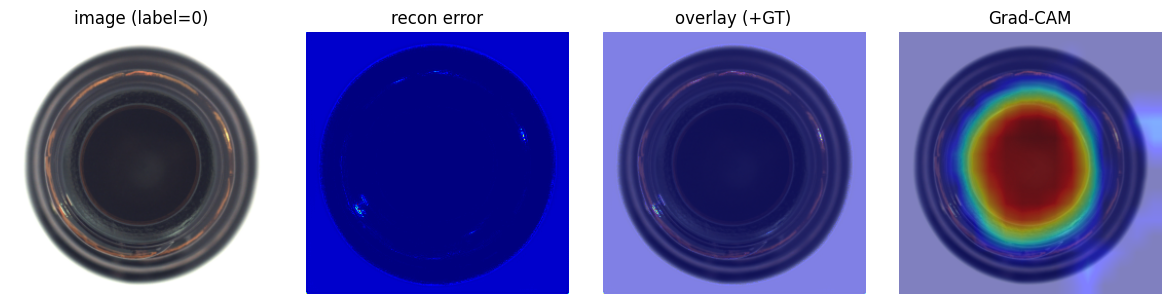

[SAVED] ./out_unet_ae/vis_bottle_cam/normal_idx63_score0.000510.png


In [6]:
# =====================================================
# セル4: 正常例を1枚だけ可視化（画像/誤差/GT/Grad-CAM）
# 依存: セル3まで実行済み（show_example, scores_np, preds, labels_np, vis_cam_dir など）
# =====================================================
import os
import numpy as np

# vis_cam_dir が無い場合に備えて
if 'vis_cam_dir' not in globals():
    vis_cam_dir = os.path.join(OUT_DIR, f"vis_{CLASS_NAME}_cam")
    os.makedirs(vis_cam_dir, exist_ok=True)

# まず「真のラベルが正常(0)」から1つ選ぶ。無ければ「予測が正常(0)」から。
idx_candidates = np.where(labels_np == 0)[0]
if len(idx_candidates) == 0:
    idx_candidates = np.where(preds == 0)[0]
if len(idx_candidates) == 0:
    idx_candidates = [0]  # 最後の保険

i = int(idx_candidates[0])
print(f"[NORMAL] idx={i}, score={scores_np[i]:.6f}, pred={preds[i]}(0=good), true={labels_np[i]}")

save_path = os.path.join(vis_cam_dir, f"normal_idx{i}_score{scores_np[i]:.6f}.png")
show_example(i, save_path=save_path, use_gradcam=True)
print("[SAVED]", save_path)


[THRESH] tau = 0.001032 (99.5-percentile of validation-good)

[CONFUSION MATRIX] (rows=true, cols=pred) labels=[good(0), anomaly(1)]
[[19  1]
 [34 29]]

[REPORT]
              precision    recall  f1-score   support

        good     0.3585    0.9500    0.5205        20
     anomaly     0.9667    0.4603    0.6237        63

    accuracy                         0.5783        83
   macro avg     0.6626    0.7052    0.5721        83
weighted avg     0.8201    0.5783    0.5988        83


[SHOW] Top-8 predicted anomalies (by image score)


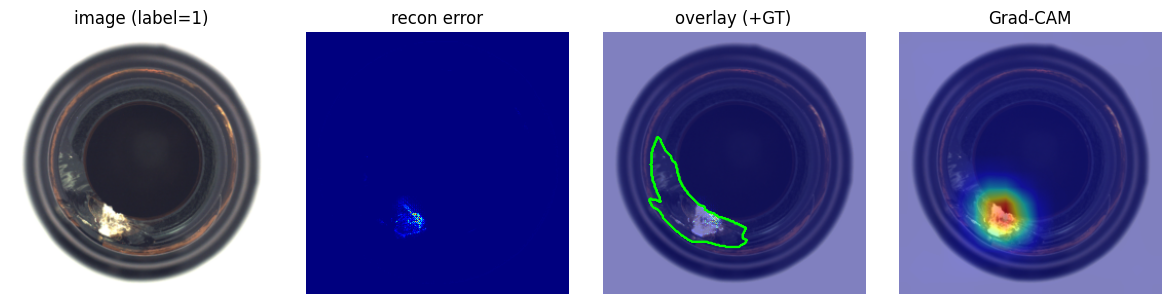

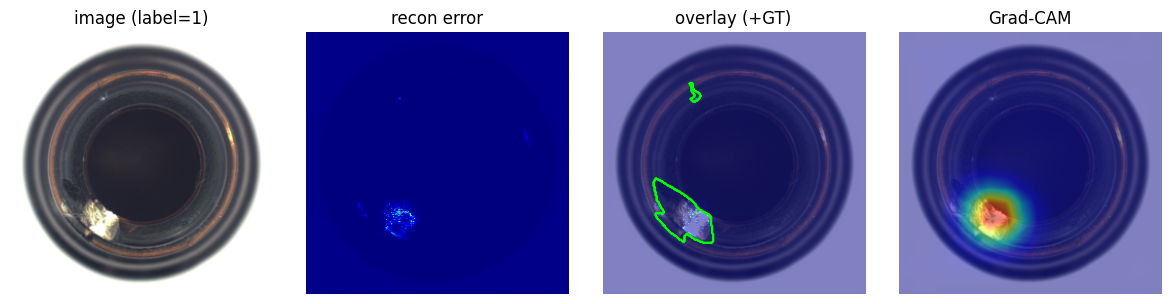

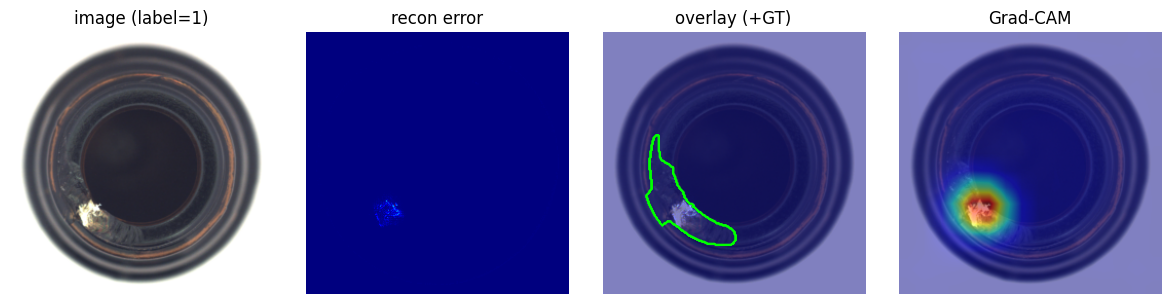

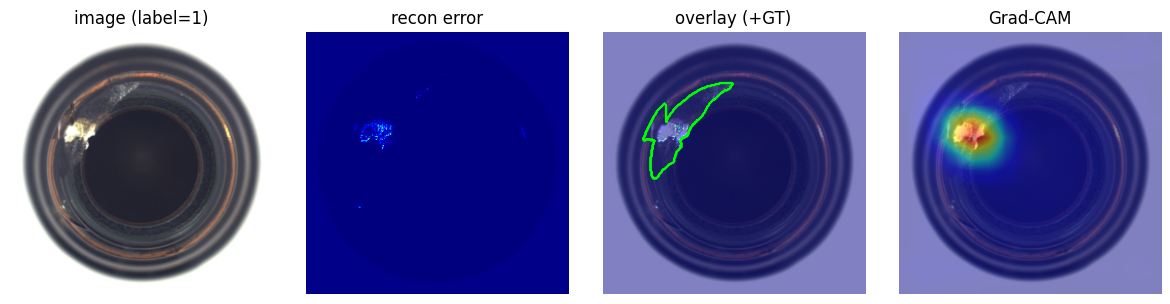

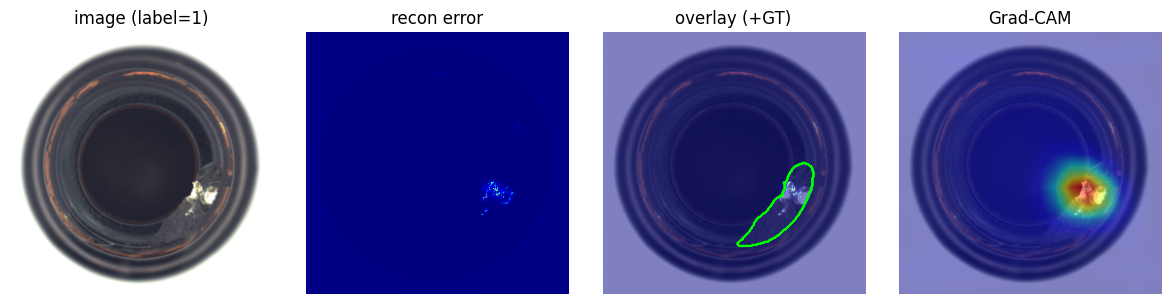

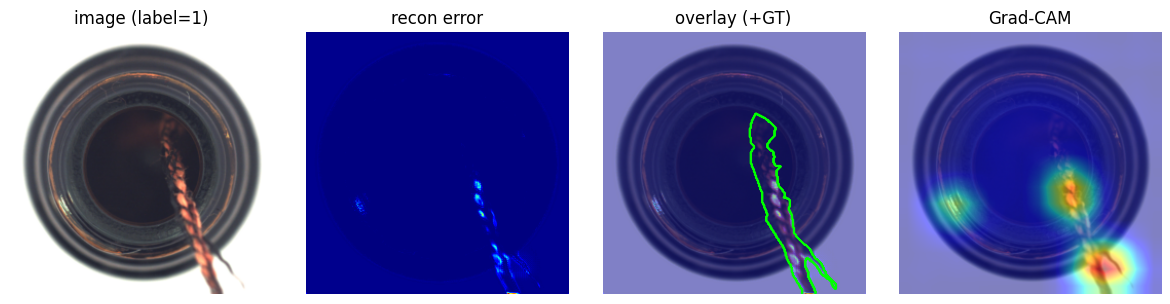

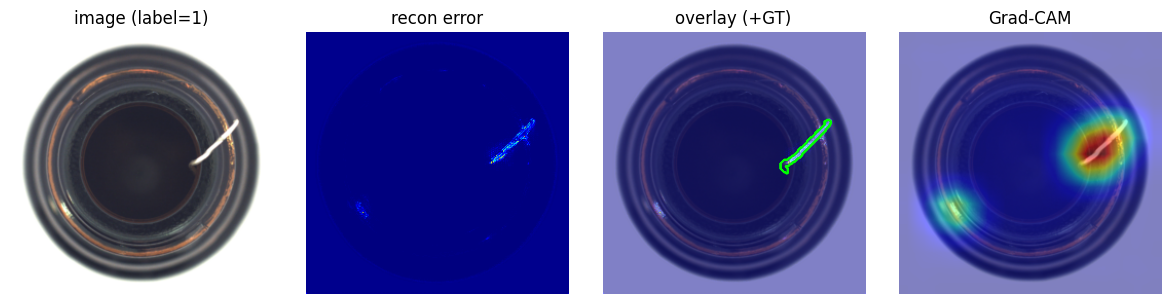

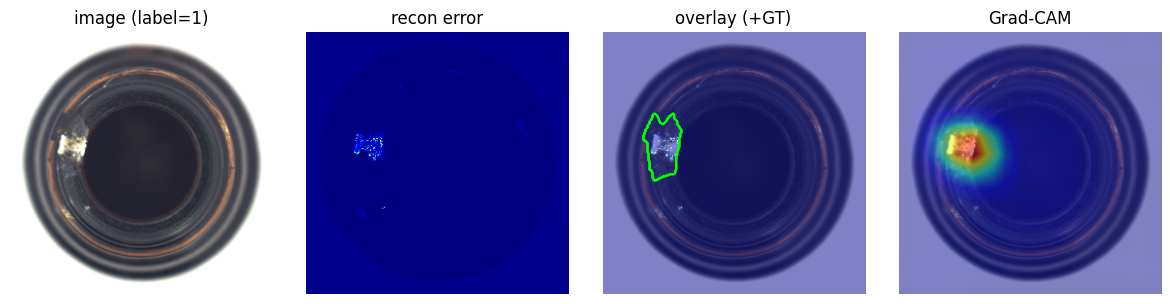


[SHOW] FP examples (pred=1,true=0): [71]


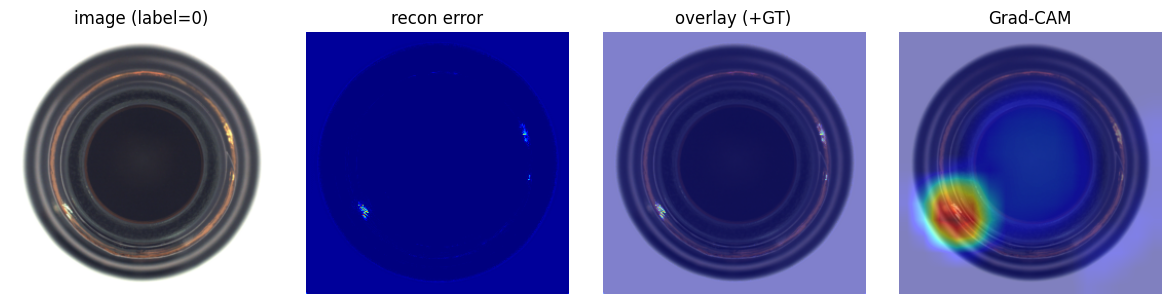


[SHOW] FN examples (pred=0,true=1): [0, 2, 3, 5]


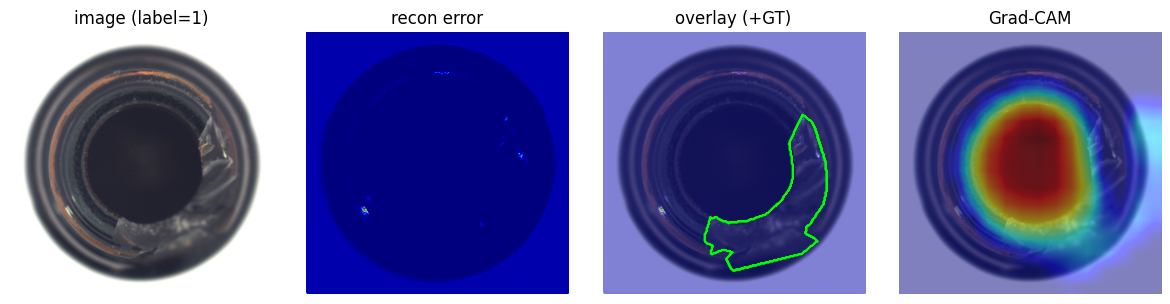

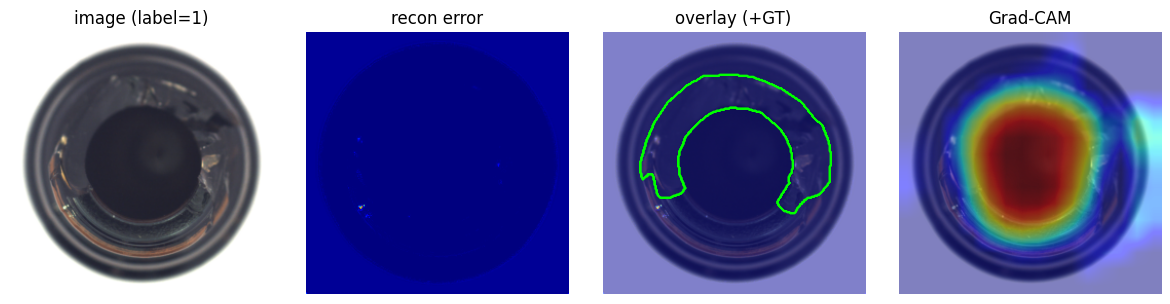

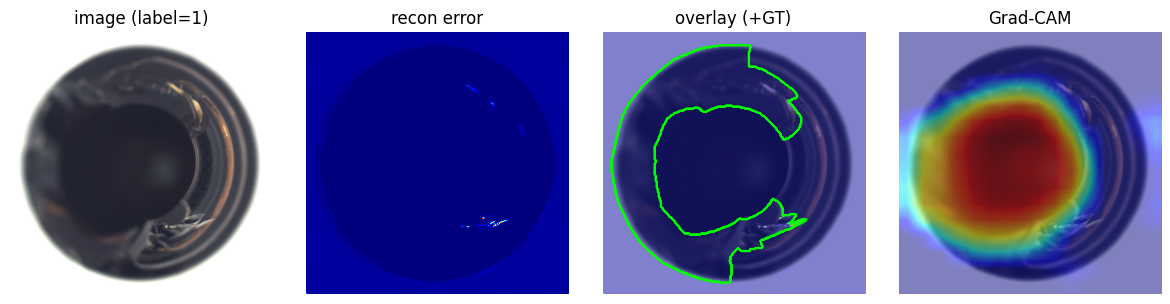

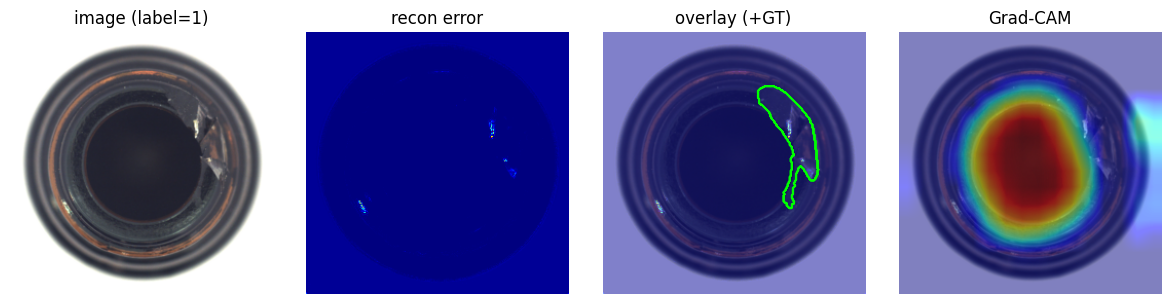


[DONE] 可視化PNGは: ./out_unet_ae/vis_bottle_cam


In [5]:
# =====================================================
# セル3: 判定・可視化（inline表示＋PNG保存＋Grad-CAM）
#  - 閾値学習（valの正常分布から推定）→ テスト判定（正常/異常）
#  - 混同行列・分類レポートを表示
#  - 上位スコアの異常例、FP/FN例を表示＆保存
#  - 再構成誤差ヒートマップ＋GT輪郭＋Grad-CAMを重畳表示
# 依存: セル2で学習・評価済み（model, ds_te, dl_te, dl_va or dl_tr, scores, labels, ...）
# 出力: ./out_unet_ae/vis_<CLASS_NAME>_cam/
# =====================================================

import os, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------------------------------
# 0) 前提チェックと保存先
# -----------------------------------------------------
assert 'model' in globals(), "model が見つかりません（先にセル2を実行してください）"
assert 'ds_te' in globals() and 'dl_te' in globals(), "テストデータが見つかりません（先にセル2を実行してください）"
assert 'scores' in globals() and 'labels' in globals(), "scores/labels が見つかりません（先にセル2を実行してください）"
assert 'CLASS_NAME' in globals() and 'OUT_DIR' in globals(), "CLASS_NAME/OUT_DIR が見つかりません（セル2と揃えてください）"
assert 'device' in globals(), "device が見つかりません（先にセル2を実行してください）"

vis_cam_dir = os.path.join(OUT_DIR, f"vis_{CLASS_NAME}_cam")
os.makedirs(vis_cam_dir, exist_ok=True)

# -----------------------------------------------------
# 1) 閾値推定（valの正常上位百分位）→ テスト判定
# -----------------------------------------------------
@torch.no_grad()
def image_scores_from_loader(loader, top_p=0.01):
    model.eval()
    sc = []
    for batch in loader:
        x = batch if isinstance(batch, torch.Tensor) else batch[0]  # (x) or (x,...) 両対応
        x = x.to(device)
        y = model(x)
        l2map = ((x - y)**2).mean(1, keepdim=True)   # (B,1,H,W)
        m = l2map.view(l2map.size(0), -1)
        k = max(1, int(m.size(1)*top_p))
        sc.extend(torch.topk(m, k=k, dim=1).values.mean(1).cpu().numpy().tolist())
    return np.array(sc, dtype=np.float32)

# valが無ければ学習バッチで代用
try:
    val_scores = image_scores_from_loader(dl_va, top_p=0.01)
except Exception as e:
    print("[WARN] dl_va が見つからないため、閾値推定に学習データを代用します:", repr(e))
    val_scores = image_scores_from_loader(dl_tr, top_p=0.01)

tau = float(np.percentile(val_scores, 99.5))  # 正常の 99.5% を上限（FP抑制寄り）
print(f"[THRESH] tau = {tau:.6f} (99.5-percentile of validation-good)")

scores_np = np.asarray(scores, dtype=np.float32)
labels_np = np.asarray(labels, dtype=np.int64)
preds = (scores_np > tau).astype(np.int64)

print("\n[CONFUSION MATRIX] (rows=true, cols=pred) labels=[good(0), anomaly(1)]")
print(confusion_matrix(labels_np, preds, labels=[0,1]))
print("\n[REPORT]")
print(classification_report(labels_np, preds, target_names=["good","anomaly"], digits=4))

# -----------------------------------------------------
# 2) Grad-CAM ユーティリティ（U-Netの層名に依存しない）
# -----------------------------------------------------
def get_cam_target_layer(model: nn.Module):
    """U-Net のボトルネック（bottleneck/bn）の最後のConvを優先。無ければモデル内の最後のConv2d。"""
    for name in ("bottleneck", "bn"):
        if hasattr(model, name):
            block = getattr(model, name)
            seq = getattr(block, "net", None)
            if isinstance(seq, nn.Sequential):
                convs = [m for m in seq if isinstance(m, nn.Conv2d)]
                if convs:
                    return convs[-1]
    last_conv = None
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            last_conv = m
    return last_conv  # Noneの可能性もある

def compute_gradcam(x: torch.Tensor, model: nn.Module, target_layer: nn.Module):
    """再構成誤差（全画素平均）をスカラー目的として Grad-CAM を計算。"""
    feats = grads = None
    def fwd_hook(m, inp, out):
        nonlocal feats; feats = out
    def bwd_hook(m, gin, gout):
        nonlocal grads; grads = gout[0]
    h1 = target_layer.register_forward_hook(fwd_hook)
    try:
        h2 = target_layer.register_full_backward_hook(bwd_hook)  # PyTorch 2 推奨
    except Exception:
        h2 = target_layer.register_backward_hook(bwd_hook)       # 旧APIフォールバック

    x = x.clone().requires_grad_(True)
    y = model(x)
    l2map = ((x - y)**2).mean(1, keepdim=True)    # (B,1,H,W)
    score = l2map.mean()                           # スカラー（画像全体の誤差）
    model.zero_grad(set_to_none=True)
    score.backward()

    with torch.no_grad():
        w = grads.mean(dim=(2,3), keepdim=True)        # (B,C,1,1)
        cam = (w * feats).sum(dim=1, keepdim=True)     # (B,1,h,w)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        cam_np = cam.squeeze().cpu().numpy()

    h1.remove(); h2.remove()
    x.requires_grad_(False)
    return cam_np

def show_example(idx: int, save_path: str = None, use_gradcam: bool = True):
    """画像/誤差ヒートマップ/GT/Grad-CAM を並べて表示し、必要なら保存。"""
    img, gtmask, ylab = ds_te[idx]
    x = img.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        y = model(x)
        l2map = ((x - y)**2).mean(1, keepdim=True)  # (1,1,H,W)
        hm = l2map.squeeze().cpu().numpy()

    cam_np = None
    if use_gradcam:
        tgt = get_cam_target_layer(model)
        if tgt is None:
            print("[WARN] Grad-CAM 対象の Conv2d が見つからないためスキップします。")
        else:
            try:
                cam_np = compute_gradcam(x, model, tgt)
            except Exception as e:
                print("[WARN] Grad-CAM 失敗:", repr(e))

    im = img.permute(1,2,0).cpu().numpy()
    hm_n = (hm - hm.min()) / (hm.max() - hm.min() + 1e-8)

    plt.figure(figsize=(12,3))
    ax1 = plt.subplot(1,4,1); ax1.imshow(im); ax1.set_title(f"image (label={ylab})"); ax1.axis('off')
    ax2 = plt.subplot(1,4,2); ax2.imshow(hm_n, cmap='jet'); ax2.set_title("recon error"); ax2.axis('off')
    ax3 = plt.subplot(1,4,3); ax3.imshow(im); ax3.imshow(hm_n, cmap='jet', alpha=0.5)
    try:
        cnt = (gtmask[0].numpy() > 0).astype(np.uint8)
        ax3.contour(cnt, colors='lime', linewidths=1)
    except Exception:
        pass
    ax3.set_title("overlay (+GT)"); ax3.axis('off')
    ax4 = plt.subplot(1,4,4)
    if cam_np is not None:
        ax4.imshow(im); ax4.imshow(cam_np, cmap='jet', alpha=0.5); ax4.set_title("Grad-CAM")
    else:
        ax4.text(0.5,0.5,"CAM N/A", ha='center', va='center')
    ax4.axis('off')
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=150)
    plt.show()

# -----------------------------------------------------
# 3) 上位異常（score高）と FP/FN の可視化
# -----------------------------------------------------
order = np.argsort(-scores_np)  # 降順インデクス
top_k = int(min(8, len(order))) # 表示枚数
print(f"\n[SHOW] Top-{top_k} predicted anomalies (by image score)")
for r in range(top_k):
    i = int(order[r])
    sp = os.path.join(vis_cam_dir, f"top{r:02d}_idx{i}_score{scores_np[i]:.6f}_pred{preds[i]}_true{labels_np[i]}.png")
    show_example(i, save_path=sp, use_gradcam=True)

fp_idx = [i for i in range(len(preds)) if preds[i]==1 and labels_np[i]==0][:4]
fn_idx = [i for i in range(len(preds)) if preds[i]==0 and labels_np[i]==1][:4]
print(f"\n[SHOW] FP examples (pred=1,true=0): {fp_idx}")
for i in fp_idx:
    sp = os.path.join(vis_cam_dir, f"FP_idx{i}_score{scores_np[i]:.6f}.png")
    show_example(i, save_path=sp, use_gradcam=True)

print(f"\n[SHOW] FN examples (pred=0,true=1): {fn_idx}")
for i in fn_idx:
    sp = os.path.join(vis_cam_dir, f"FN_idx{i}_score{scores_np[i]:.6f}.png")
    show_example(i, save_path=sp, use_gradcam=True)

print(f"\n[DONE] 可視化PNGは: {vis_cam_dir}")


[LOAD] ./out_unet_ae/scores_bottle.npy, ./out_unet_ae/labels_bottle.npy


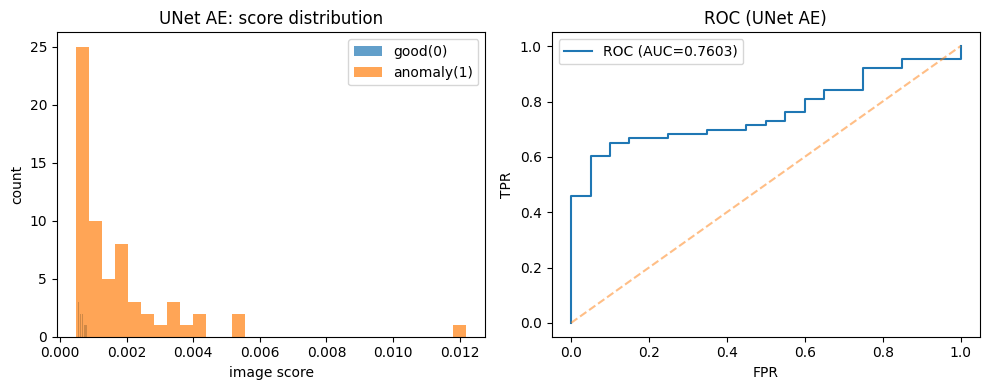

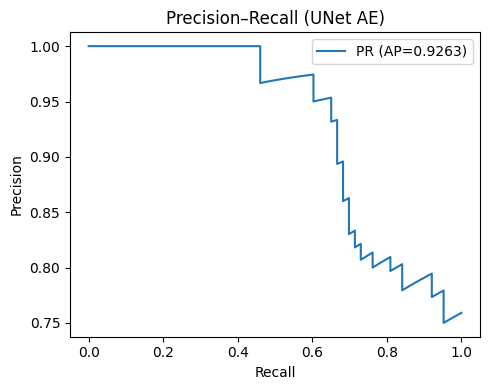

[SUGGEST] tau_youden=0.000900, tau_f1=0.000492

=== @ YoudenJ: tau=0.000900 ===
[[19  1]
 [26 37]]
              precision    recall  f1-score   support

        good     0.4222    0.9500    0.5846        20
     anomaly     0.9737    0.5873    0.7327        63

    accuracy                         0.6747        83
   macro avg     0.6980    0.7687    0.6586        83
weighted avg     0.8408    0.6747    0.6970        83


=== @ F1-best: tau=0.000492 ===
[[ 0 20]
 [ 1 62]]
              precision    recall  f1-score   support

        good     0.0000    0.0000    0.0000        20
     anomaly     0.7561    0.9841    0.8552        63

    accuracy                         0.7470        83
   macro avg     0.3780    0.4921    0.4276        83
weighted avg     0.5739    0.7470    0.6491        83



In [7]:
# ===== 追加セルUA：UNet AE のスコア解析 & しきい値チューニング =====
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report

# クラス名の推定（未定義なら bottle）
try:
    CLASS_NAME
except NameError:
    CLASS_NAME = "bottle"

# まずは保存済み .npy から読み込み（推奨）。無ければメモリ上の scores/labels を試す。
unet_dir = "./out_unet_ae"
sc_path = os.path.join(unet_dir, f"scores_{CLASS_NAME}.npy")
lb_path = os.path.join(unet_dir, f"labels_{CLASS_NAME}.npy")

if os.path.exists(sc_path) and os.path.exists(lb_path):
    scores_u = np.load(sc_path)
    labels_u = np.load(lb_path)
    print(f"[LOAD] {sc_path}, {lb_path}")
elif 'scores' in globals() and 'labels' in globals():
    # 注意：PaDiMの scores/labels と混同しないように、できれば .npy 保存を使ってください
    scores_u = np.asarray(scores, dtype=np.float32)
    labels_u = np.asarray(labels, dtype=np.int64)
    print("[WARN] Using in-memory scores/labels (手元のscores/labelsがPaDiMのものでないか確認推奨)")
else:
    raise FileNotFoundError("UNetのスコアが見つかりません。先にUNetセル2を実行して .npy が保存されているか確認してください。")

# --- 1) スコア分布 ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(scores_u[labels_u==0], bins=30, alpha=0.7, label='good(0)')
plt.hist(scores_u[labels_u==1], bins=30, alpha=0.7, label='anomaly(1)')
plt.title("UNet AE: score distribution")
plt.xlabel("image score"); plt.ylabel("count"); plt.legend()

# --- 2) ROC & PR ---
fpr, tpr, thr = roc_curve(labels_u, scores_u)
roc_auc = auc(fpr, tpr)
prec, rec, thr_pr = precision_recall_curve(labels_u, scores_u)
ap = average_precision_score(labels_u, scores_u)

plt.subplot(1,2,2)
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.4f})")
plt.plot([0,1],[0,1],'--',alpha=0.5)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (UNet AE)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"PR (AP={ap:.4f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall (UNet AE)")
plt.legend(); plt.tight_layout(); plt.show()

# --- 3) 最適しきい値の提案（Youden J と F1最大） ---
youden_idx = np.argmax(tpr - fpr)
tau_youden = float(thr[youden_idx])

f1_vals = 2*prec*rec/(prec+rec+1e-12)
best_f1_idx = np.nanargmax(f1_vals[:-1])  # thr_pr は1つ短い
tau_f1 = float(thr_pr[best_f1_idx])

print(f"[SUGGEST] tau_youden={tau_youden:.6f}, tau_f1={tau_f1:.6f}")

def eval_at_tau(scores, labels, tau, name):
    preds = (scores > tau).astype(int)
    print(f"\n=== @ {name}: tau={tau:.6f} ===")
    print(confusion_matrix(labels, preds, labels=[0,1]))
    print(classification_report(labels, preds, target_names=['good','anomaly'], digits=4))

eval_at_tau(scores_u, labels_u, tau_youden, "YoudenJ")
eval_at_tau(scores_u, labels_u, tau_f1,     "F1-best")
